## Conda Env:
venvMmDet

# In these notebook I am going to finetune Faster R-CNN model for stomata detection.

* In the first part I briefly explore the images data.
* Next I finetune baseline stomata detection model based on Faster R-CNN in PyTorch.
* Finally I evaluate and visualize some results of the detection model.

In [1]:
%env WANDB_NOTEBOOK_NAME frcnn_rn50.ipynb

env: WANDB_NOTEBOOK_NAME=frcnn_rn50.ipynb


In [2]:
import numpy as np
import pandas as pd 
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from PIL import Image

import os
from tqdm import tqdm
from IPython.display import clear_output

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from xml.etree import ElementTree as et

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import utils

import random

import wandb

# torch.cuda.empty_cache() 

In [3]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="FasterRCNN",
)

wandb: Currently logged in as: samad. Use `wandb login --relogin` to force relogin


In [4]:
DATA_PATH = os.getcwd()

# the directory of the images are stored 
data_dir = os.path.join(os.getcwd(), 'data/all_images')

# the directory with train images and lebesls
training_dir = os.path.join(data_dir, 'train')

# the directory with test images and lebesls
testing_dir = os.path.join(data_dir, 'test')


# stucture of the directory

# data  --|
#         |-train---|
#         |         |-img
#         |         |-label
#         |
#         |-test--- |
#         |         |-img
#         |         |-label

## 1. Brief images exploration:
First let's plot some random images with corresponding stomata bounding-boxes.

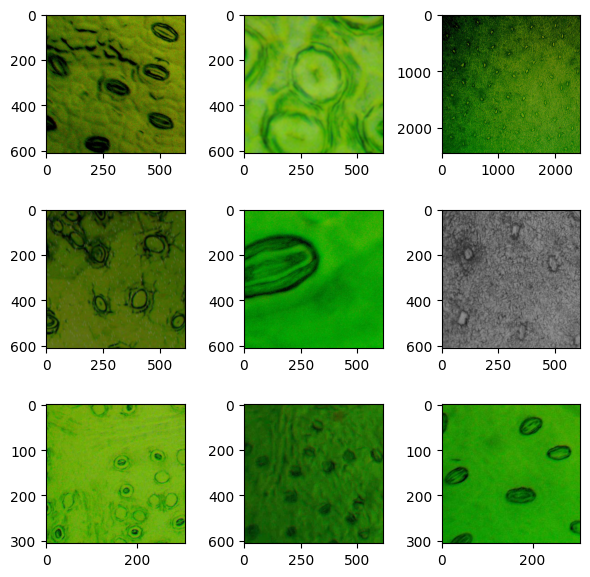

In [5]:
def plot_random_images(image_dir, no_of_row = 2, no_of_col = 2, plot_bboxes=False):
    
    img_dir = image_dir

    img_list = os.listdir(img_dir + '/')

    # we cannot use ax[i][j] if row is not greater than 1 so we make sure it is always greater than 1
    no_of_row = 2 if no_of_row <= 1 else no_of_row

    fig, ax = plt.subplots(no_of_row, no_of_col, figsize=(6, 6))

    for row in range(no_of_row):
        for col in range(no_of_col):
            ax[row][col].imshow(Image.open(image_dir + "/"  + img_list[random.randint(0, len(img_list)-1)] ))
    fig.tight_layout()


plot_random_images(training_dir + '/img', no_of_row = 3, no_of_col = 3)

## 2. Finetune Faster R-CNN

First let's implement class for data handling that fits PyTorch Faster R-CNN implementation's needs:

In [7]:
class StomataDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.height = height
        self.width = width
        self.image_dir = files_dir + '/img/'
        self.label_dir = files_dir + '/label/'
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(self.image_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_,  'stomata']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.image_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.label_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)



# defining the files directory and testing directory
files_dir = training_dir

# check training_set
training_set = StomataDataset(training_dir, 608, 608)

print('length of training_set = ', len(training_set), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = training_set[1]
# print(img.shape, '\n',target)

length of training_set =  14112 



Now let's write a helper function to build a model that fits our number of classes. Notice that here are 1 class of stomata and class 0 that corresponds to the background, which makes 2 classes in total. <br>
As we are aiming to finetune, we can use Faster R-CNN pretrained on COCO dataset, change number of classes in its head and train it:

In [8]:
def get_model(n_classes=2):
    # model pretrained on COCO training_set
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    # original number of features in classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # adapting number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
    return model

In [9]:
def forward_train(model, data, device):
    imgs, targets = data
    imgs = [image.to(device) for image in imgs]
    targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
    
    loss_dict = model(imgs, targets) 
    losses = sum(loss for loss in loss_dict.values())
    
    return losses

Now let's prepare train and test datasets:

In [10]:
# One more helper function in order to handle batches with different shapes
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
# Send train=True fro training transforms and False for val/test transforms

def get_transform(train):
    
    # if train:
    #     return A.Compose([
    #                         A.HorizontalFlip(0.5),
    #                  # ToTensorV2 converts image to pytorch tensor without div by 255
    #                         ToTensorV2(p=1.0) 
    #                     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    # else:
    #     return A.Compose([
    #                         ToTensorV2(p=1.0)
    #                     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    
    return A.Compose([
                        ToTensorV2(p=1.0)
                    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [14]:
BATCH_SIZE = 6 # Here I am use small batch size in order to avoid kernel crash
# N_TEST = 2

training_set = StomataDataset(training_dir, 608, 608, get_transform(train=True))
test_set = StomataDataset(testing_dir, 608, 608, transforms= get_transform(train=False))

# train and test split
idxs = torch.randperm(len(training_set)).tolist()

                      
train_dataloader = torch.utils.data.DataLoader(training_set,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4,
                                               collate_fn=collate_fn)
                      
test_dataloader = torch.utils.data.DataLoader(test_set,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=2,
                                               collate_fn=collate_fn)

print(len(train_dataloader))
print(len(test_dataloader))

2352
741


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')
model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model.to(device)

Device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

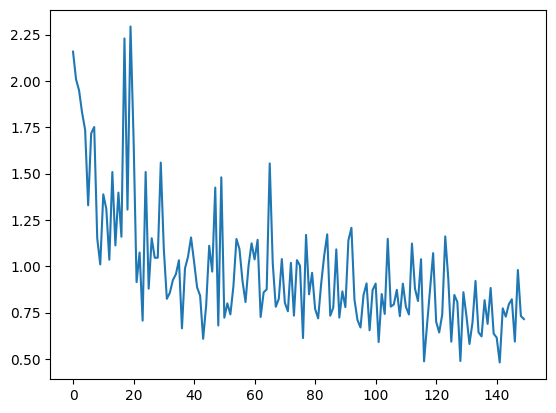

batch loss: 0.7152947783470154, average loss: 0.9790116918087005.: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


In [16]:
N_ITERS = 150

train_dataloader = train_dataloader
test_dataloader = test_dataloader

progress_bar = tqdm(range(N_ITERS))
tr_it = iter(train_dataloader)
loss_log = []
iterations = []

for i in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    
    losses = forward_train(model, data, device)
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
        
    loss_log.append(losses.item())
    iterations.append(i)
    progress_bar.set_description(f'batch loss: {losses.item()}, average loss: {np.mean(loss_log)}.')
    
    clear_output(True)
    plt.plot(iterations, loss_log)
    plt.show()

## 3. Model evaluation:
After small training we can inspect result of stomata detection on test data. 

In [ ]:
def plot_detected_bboxes(test_img, predictions, n_to_plot=2, score_threshold=0.5):
    
    n = min(len(test_img), n_to_plot)
    
    fig, ax = plt.subplots(1, n, figsize=(16, 8))
    
    for i in range(n):
        img = np.asarray(test_img[i].cpu().numpy() * 255, dtype=np.int64)
        img = np.moveaxis(img, 0, 2)
        img = Image.fromarray(np.uint8(img)).convert('RGB')
        ax[i].imshow(img)
        ax[i].set_axis_off()

        bboxes = predictions[i]['boxes'].cpu().numpy()
        scores = predictions[i]['scores'].cpu().numpy()
        scores_mask = scores > score_threshold
        for bbox in bboxes[scores_mask]:
            patch = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0], bbox[3] - bbox[1],
                linewidth=1,
                edgecolor='b',
                facecolor='None',
                alpha=0.8)
            ax[i].add_patch(patch)  
        
    fig.tight_layout()
    return 

In [ ]:
model.eval()
torch.set_grad_enabled(False)

test_it = iter(test_dataloader)

test_img, test_gt  = next(test_it)
test_img = [image.to(device) for image in test_img]

predictions = model(test_img)

plot_detected_bboxes(test_img, predictions,
                     n_to_plot=4,
                     score_threshold=.6)

---

## Possible steps to continue:
1. Explore stomata visibility labels influence on model performance (try training only on a nicely visible stomata or not separating visibility at all).
2. Try another backbone model.
3. Experiment with optimizer, learning rate schedule, batch size, number or iterations, etc.
4. Add data augmentations.
5. Try RetinaNet, YOLO or some different detector arcitecture.
6. Optimize data loader to make it faster.